In [1]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [2]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

NameError: name 'bigquery_client' is not defined

In [3]:
test_df.drop_duplicates()

NameError: name 'test_df' is not defined

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [6]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import csv
import numpy as np

In [8]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
global df3

In [10]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [12]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=d29609bc-10df-43fd-8563-c66da80dc7bc>

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [14]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=c89044be-9409-4a14-86b4-e5c9e93ea4ee>

In [15]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [16]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [44]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [45]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

In [46]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [47]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [48]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [49]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [50]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [51]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5438/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.9391144116847102
     jac: array([-4.72836196e-04, -2.24843621e-04,  1.12153590e-04, -2.12490559e-05,
       -8.30739737e-05,  3.21738422e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 229
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([1.03927724, 1.33562453, 1.35915665, 2.25884102, 0.35523893,
       0.23445896, 1.        ])

In [52]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 813858.1207688724
     jac: array([812211.1171875, 337886.       ,      0.       ,      0.       ,
            0.       ,      0.       ,      0.       ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [53]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [54]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5438/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048890,0.030031,-0.145223
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024650,-0.024748,0.027384
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034986,-0.035626,0.033948
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034968,0.036536,-0.029560
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266271,0.266751,-0.259220
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040827,0.040380,-0.022586
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400


In [55]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783864,0.781382,-0.765767
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625488,0.621388,-0.604602
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.844055,0.840822,-0.824220
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956102,0.952537,-0.933356
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.858039,0.855521,-0.839424
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983388,0.979974,-0.960823


In [56]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


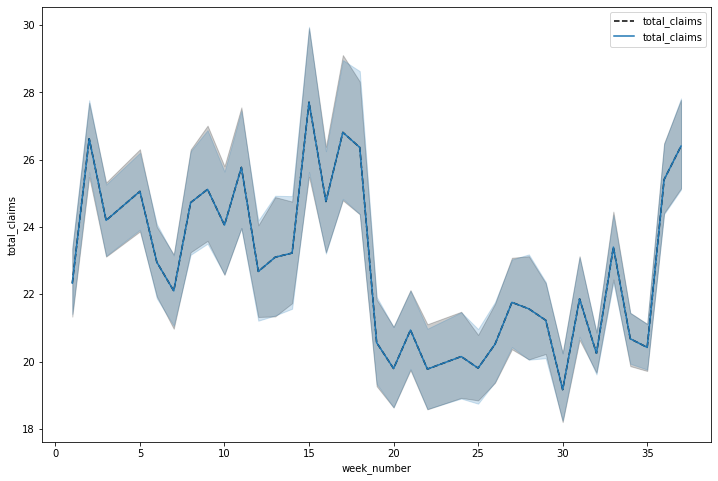

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


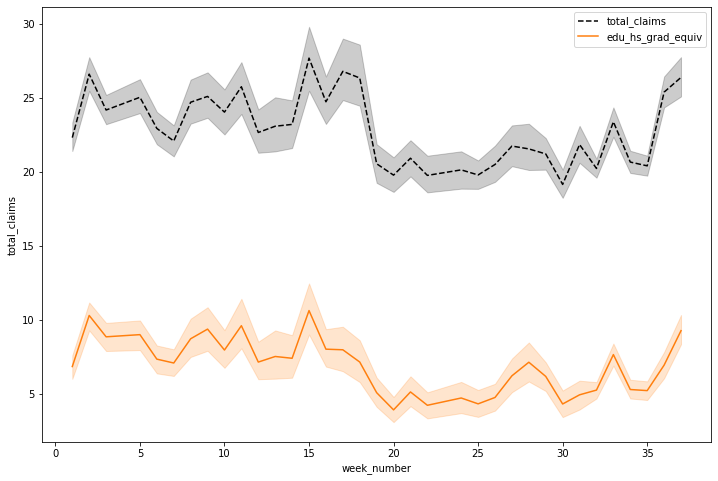

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


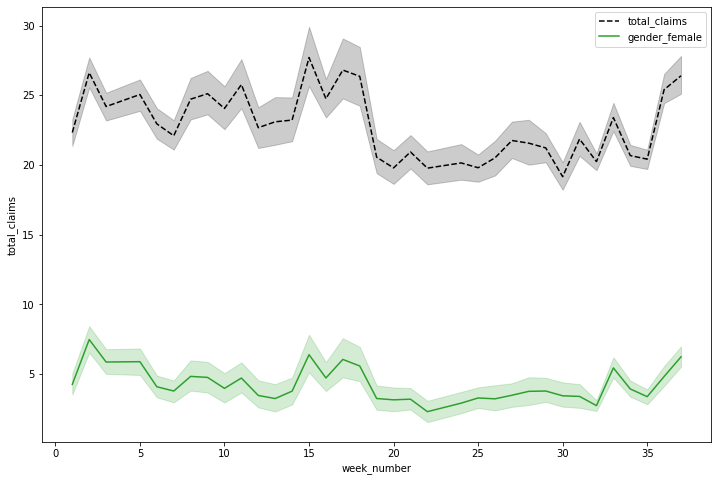

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


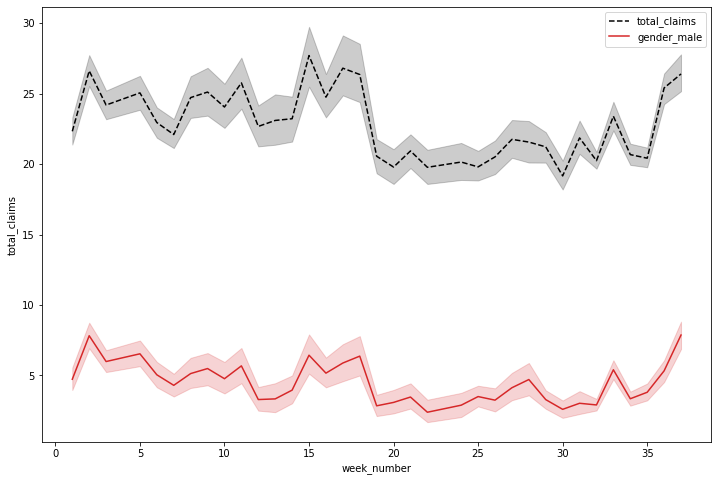

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


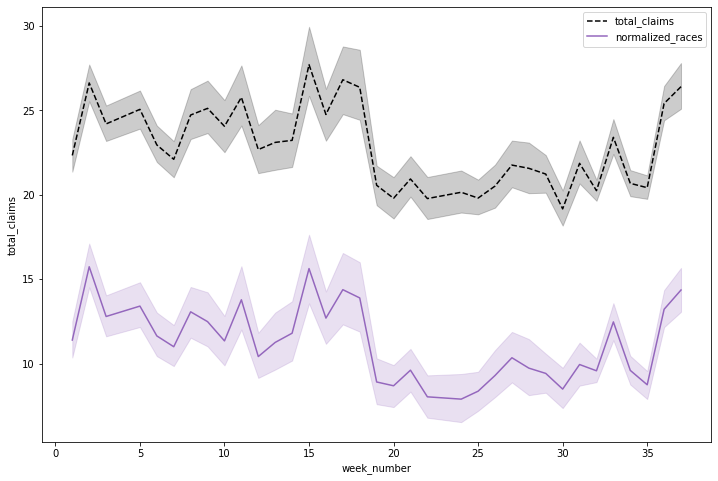

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


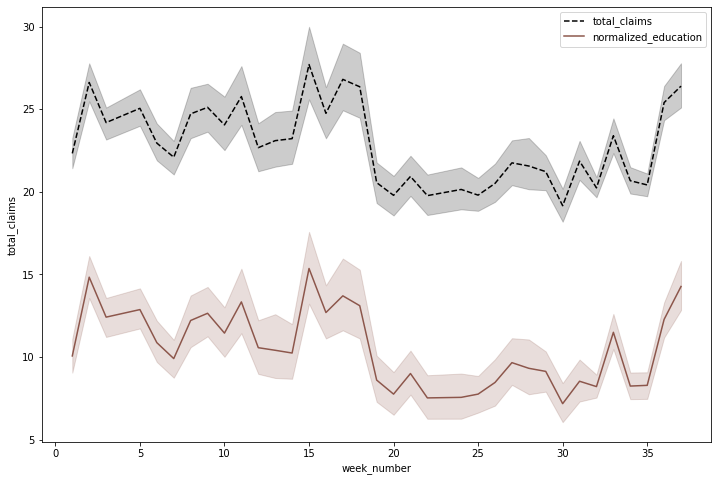

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


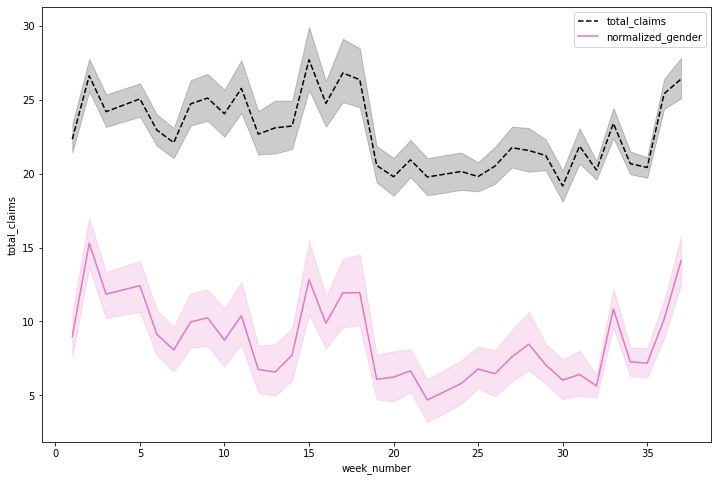

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


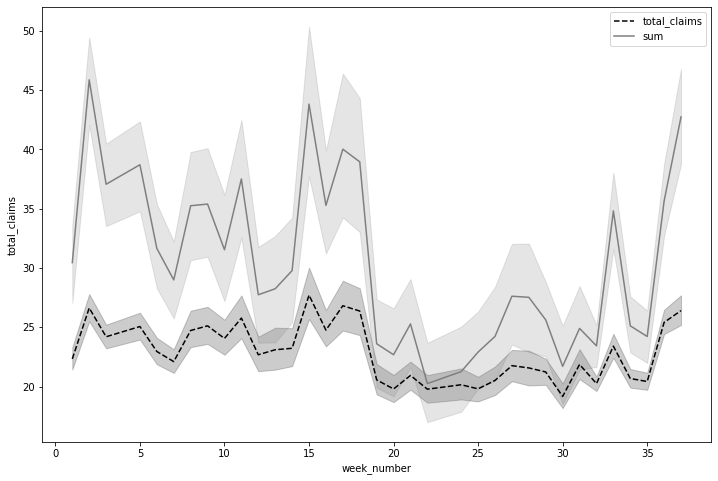

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


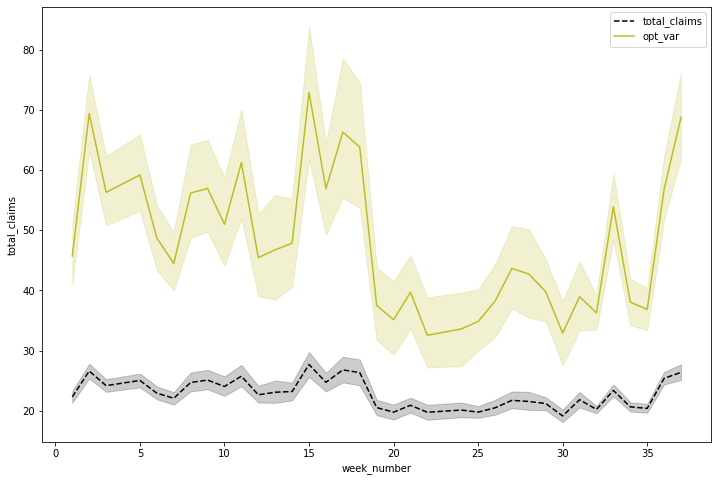

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


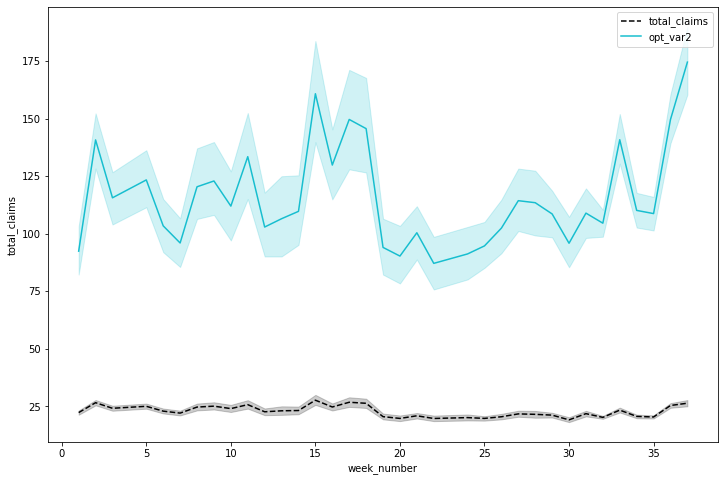

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


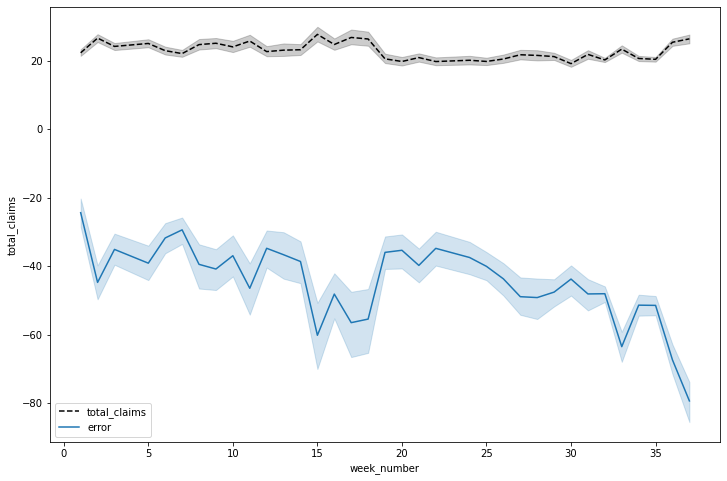

In [57]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

In [58]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [59]:
def final_pred(t):
    Y = np.array(t["total_claims"])
    X = np.array(t[[k for k in features]])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.01, random_state =5)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    rf = rg(n_estimators=1000, random_state=2)
    rf.fit(X_train, Y_train)
    return rf

In [60]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.816011,105.632023,-38.816011
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.726515,82.453030,-40.726515
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.179821,107.359642,-35.179821


In [61]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [62]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

In [63]:
test_df.drop_duplicates()

,uu_id,week_number,day,month
0,5bf51fc2e162d6faf9e3cf79e4198378,44,6,11
1,420b44cc7e3f55d738df565421e59941,44,6,11
2,e39c66ecceec76ee8f9f811fa4a2d246,44,6,11
3,a90462cd11ae4e43144239bf7c4828a4,44,6,11
4,8b20a6749088c7ff1237983076ebfeaa,44,6,11
...,...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,6,11
521,1deebda501712e7595b531b8337bc31a,44,6,11
522,5a9758f65f001b6432ff31ff64a459d7,44,6,11
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,6,11


In [64]:
"""extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())
extra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]
extra"""

'extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())\nextra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]\nextra'

In [65]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id").drop(["uu_id"], axis=1).drop_duplicates()
feature_test_pred = test_df.copy()
test_df

,week_number,day,month,uu_id_enc
0,44,6,11,198.0
10,44,6,11,126.0
18,44,6,11,476.0
32,44,6,11,353.0
58,44,6,11,288.0
...,...,...,...,...
16684,44,6,11,144.0
16722,44,6,11,52.0
16757,44,6,11,192.0
16781,44,6,11,486.0


In [66]:
"""test_df1=test_df.copy()
for col in ['total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in extra:
        #test_df.loc[test_df.uu_id_enc==k,col] =0
        temp=df[df.uu_id_enc == k]
        temp["average_wage"]=-9999
        temp =temp.replace("",0)
        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])
        #print(k, temp)
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        idk = float(val.predict(np.array(feature_test_pred))[0])
        print(idk)
        test_df.loc[test_df.uu_id_enc==k,col].value  = idk
test_df"""

'test_df1=test_df.copy()\nfor col in [\'total_claims\', \'edu_8th_or_less\', \'edu_grades_9_11\',\n       \'edu_hs_grad_equiv\', \'edu_post_hs\', \'edu_unknown\',\n       \'top_category_employer1\', \'top_category_employer2\',\n       \'top_category_employer3\', \'gender_female\', \'gender_male\', \'gender_na\',\n       \'race_amerindian\', \'race_asian\', \'race_black\', \'race_noanswer\',\n       \'race_hawaiiannative\', \'race_other\', \'race_white\', \'average_wage\']:\n    print(col)\n    test_df[col]=0\n    val = ("rf")+"_"+str(col) \n    for k in extra:\n        #test_df.loc[test_df.uu_id_enc==k,col] =0\n        temp=df[df.uu_id_enc == k]\n        temp["average_wage"]=-9999\n        temp =temp.replace("",0)\n        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])\n        #print(k, temp)\n        val = time_pred(temp, col)\n        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))\n        idk = float(val.predict(np.array(featur

In [67]:
df3

,uu_id,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,f013068de98db1470bd986137a0c6d23,16.0,18003.0,900.0,451,22.0,0.0,0.0,14.0,0.0,...,4.0,16.0,494.0,11.0,14.0,0.0,25.0,44.816011,105.632023,-38.816011
1,f013068de98db1470bd986137a0c6d23,7.0,18003.0,900.0,451,10.0,0.0,0.0,0.0,0.0,...,2.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,f013068de98db1470bd986137a0c6d23,35.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,8.0,27.0,494.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,f013068de98db1470bd986137a0c6d23,11.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,3.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,f013068de98db1470bd986137a0c6d23,6.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,2.0,5.0,494.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,10.0,18113.0,971900.0,516,11.0,0.0,0.0,0.0,0.0,...,3.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,33f8f477e670b3cac704f4c0faa6e318,6.0,18113.0,971900.0,516,10.0,0.0,0.0,0.0,0.0,...,2.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,33f8f477e670b3cac704f4c0faa6e318,31.0,18113.0,971900.0,516,16.0,0.0,0.0,10.0,0.0,...,7.0,30.0,100.0,0.0,10.0,0.0,10.0,25.726515,82.453030,-40.726515
16831,33f8f477e670b3cac704f4c0faa6e318,9.0,18113.0,971900.0,516,23.0,0.0,0.0,19.0,0.0,...,2.0,26.0,100.0,0.0,19.0,0.0,19.0,49.179821,107.359642,-35.179821


In [68]:
from statsmodels.tsa.stattools import adfuller
adfuller(df3["total_claims"])

(-15.17531611425783,
 6.306874201042166e-28,
 25,
 16807,
 {'1%': -3.430739141371555,
  '5%': -2.8617119850098525,
  '10%': -2.566861543233935},
 134499.30246634077)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

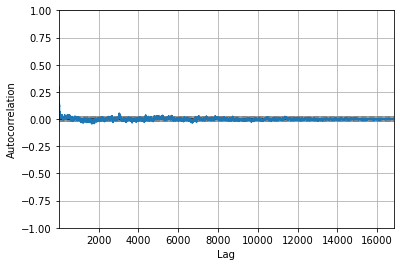

In [69]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df3["total_claims"])

In [70]:
df3 =df3.dropna()
for col in features:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in df3.uu_id_enc.unique():
        temp=df3[df3.uu_id_enc == k]
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        test_df.loc[test_df.uu_id_enc==k,col] = val.predict(np.array(feature_test_pred))[0]
test_df

total_claims


NameError: name 'time_pred' is not defined

In [71]:
#df3 =df3.dropna()
li=[]
import statsmodels.api as sm
import statistics    
for k in df3.uu_id_enc.unique():
    temp=df3[df3.uu_id_enc == k]
    temp = temp.sort_values("week_number")
    df3_ = pd.concat([temp,test_df])
    df3_=df3_[["week_number","uu_id_enc","total_claims"]].drop_duplicates()
    #df3_["predicted_total_claims"]=0
    mod = sm.tsa.statespace.SARIMAX(np.array(temp["total_claims"]),
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    try: 
        results = mod.fit()
    except IndexError:
        g = df3[df3.uu_id_enc==k]
        val= g[g.week_number==39]['total_claims'].mean()
    pred = results.get_prediction(start=40, end =40, dynamic=False)
    val = (pred.predicted_mean)
    test_df.loc[test_df.uu_id_enc==k,"total_claims"] = val
    li.append(pred.predicted_mean)
    pred_ci = pred.conf_int()
    #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51304D+00    |proj g|=  7.30584D-02

At iterate    5    f=  2.36879D+00    |proj g|=  3.32269D-01

At iterate   10    f=  2.23125D+00    |proj g|=  8.98108D-02

At iterate   15    f=  2.21721D+00    |proj g|=  5.26167D-02

At iterate   20    f=  2.21388D+00    |proj g|=  5.54893D-03

At iterate   25    f=  2.21384D+00    |proj g|=  5.16791D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54030D+00    |proj g|=  7.52304D-02

At iterate    5    f=  3.51579D+00    |proj g|=  6.69121D-02

At iterate   10    f=  3.40117D+00    |proj g|=  1.93480D-01

At iterate   15    f=  3.34747D+00    |proj g|=  8.42399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   2.970D-06   3.347D+00
  F =   3.3474265098817422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99951D+00    |proj g|=  6.55531D-02

At iterate    5    f=  2.88266D+00    |proj g|=  1.34661D-01

At iterate   10    f=  2.75969D+00    |proj g|=  2.61935D-02

At iterate   15    f=  2.75516D+00    |proj g|=  4.29083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   5.062D-06   2.755D+00
  F =   2.7551425234405076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.07642D+00    |proj g|=  6.22788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     30      1     0     0   8.871D-06   3.076D+00
  F =   3.0764158058410507     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58870D+00    |proj g|=  8.65774D-02

At iterate    5    f=  3.57191D+00    |proj g|=  4.91654D-02

At iterate   10    f=  3.48105D+00    |proj g|=  1.18312D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  1.55615D+00    |proj g|=  4.52591D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   4.526D-06   1.556D+00
  F =   1.5561496342413650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41334D+00    |proj g|=  9.16508D-02

At iterate    5    f=  3.39892D+00    |proj g|=  1.78553D-02

At iterate   10    f=  3.34732D+00    |proj g|=  1.15021D-01

At itera

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  1.58000D+00    |proj g|=  2.99696D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     44      1     0     0   2.997D-05   1.580D+00
  F =   1.5800022423487423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.61745D+15

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30868D+00    |proj g|=  6.41735D-02

At iterate   10    f=  3.15989D+00    |proj g|=  9.38311D-02

At iterate   15    f=  3.12582D+00    |proj g|=  1.44598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   3.679D-06   3.126D+00
  F =   3.1258186841055764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44778D+00    |proj g|=  7.48523D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.88921D+00    |proj g|=  5.64867D-03

At iterate   15    f=  2.88906D+00    |proj g|=  1.08848D-02

At iterate   20    f=  2.88431D+00    |proj g|=  9.47693D-02

At iterate   25    f=  2.86488D+00    |proj g|=  1.44825D-01

At iterate   30    f=  2.86246D+00    |proj g|=  5.40385D-03

At iterate   35    f=  2.86242D+00    |proj g|=  3.83112D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     50      1     0     0   3.831D-05   2.862D+00
  F =   2.8624157260696279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.59242D+00    |proj g|=  1.42143D-01

At iterate   15    f=  2.57520D+00    |proj g|=  1.09457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.395D-06   2.575D+00
  F =   2.5751931880334769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44765D+00    |proj g|=  7.14354D-01

At iterate    5    f=  2.09859D+00    |proj g|=  2.70778D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     70      2     0     0   1.500D-04   2.594D+00
  F =   2.5942901868539545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29776D+00    |proj g|=  1.76726D-01

At iterate    5    f=  2.22657D+00    |proj g|=  2.01325D-01

At iterate   10    f=  2.15956D+00    |proj g|=  3.81338D-03

At iterate   15    f=  2.15954D+00    |proj g|=  1.84504D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.49176D+00    |proj g|=  2.72761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   5.197D-05   3.492D+00
  F =   3.4917569443010104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56647D+00    |proj g|=  2.41274D-01

At iterate    5    f=  3.50878D+00    |proj g|=  5.99518D-02

At iterate   10    f=  3.41728D+00    |proj g|=  1.15659D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.80706D+00    |proj g|=  2.82068D-02

At iterate   10    f=  3.60649D+00    |proj g|=  9.31168D-02

At iterate   15    f=  3.59040D+00    |proj g|=  4.39286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.039D-05   3.590D+00
  F =   3.5903813242843916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42367D+00    |proj g|=  1.34914D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  2.75416D+00    |proj g|=  4.12920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   4.356D-06   2.754D+00
  F =   2.7541616839551049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71163D+00    |proj g|=  2.77833D-01

At iterate    5    f=  2.57546D+00    |proj g|=  2.02642D-01

At iterate   10    f=  2.45134D+00    |proj g|=  2.49049D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.56850D+00    |proj g|=  6.13623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.186D-05   2.569D+00
  F =   2.5685020499014621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74426D+00    |proj g|=  1.00880D-01

At iterate    5    f=  2.69564D+00    |proj g|=  1.28892D-01

At iterate   10    f=  2.60638D+00    |proj g|=  3.05451D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  3.02395D+00    |proj g|=  8.77551D-02

At iterate   15    f=  2.98377D+00    |proj g|=  1.40050D-02

At iterate   20    f=  2.98360D+00    |proj g|=  1.53197D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   1.532D-06   2.984D+00
  F =   2.9835975517337201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22004D+00    |proj g|=  2.84081D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.00447D+00    |proj g|=  9.20441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   6.938D-05   3.004D+00
  F =   3.0044712769854982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41558D+00    |proj g|=  3.88033D-01

At iterate    5    f=  3.25805D+00    |proj g|=  1.83536D-02

At iterate   10    f=  3.17612D+00    |proj g|=  3.89233D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93317D+00    |proj g|=  1.13346D-01

At iterate    5    f=  3.88459D+00    |proj g|=  4.09615D-02

At iterate   10    f=  3.86373D+00    |proj g|=  5.10284D-02

At iterate   15    f=  3.74706D+00    |proj g|=  1.55241D-01

At iterate   20    f=  3.68749D+00    |proj g|=  2.39256D-02

At iterate   25    f=  3.68695D+00    |proj g|=  5.75458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.11090D+00    |proj g|=  2.69828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   8.107D-06   3.111D+00
  F =   3.1109029154420131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73258D+00    |proj g|=  1.03362D-01

At iterate    5    f=  3.70998D+00    |proj g|=  5.21659D-02

At iterate   10    f=  3.59258D+00    |proj g|=  2.23362D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01085D+00    |proj g|=  5.89732D-02

At iterate   15    f=  2.98589D+00    |proj g|=  4.38600D-02

At iterate   20    f=  2.97865D+00    |proj g|=  1.96913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   9.000D-06   2.979D+00
  F =   2.9786487505586421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64243D+00    |proj g|=  2.00479D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.23068D+00    |proj g|=  3.65021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   5.300D-06   3.231D+00
  F =   3.2306759182210443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19426D+00    |proj g|=  2.20994D-01

At iterate    5    f=  2.07302D+00    |proj g|=  1.40917D-01

At iterate   10    f=  2.01482D+00    |proj g|=  4.51801D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.03026D+00    |proj g|=  5.95320D-02

At iterate   20    f=  3.00035D+00    |proj g|=  7.42243D-02

At iterate   25    f=  2.99882D+00    |proj g|=  5.72801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     41      1     0     0   7.681D-05   2.999D+00
  F =   2.9988208364126399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42199D+00    |proj g|=  1.05304D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30529D+00    |proj g|=  1.78610D-02

At iterate   10    f=  3.27515D+00    |proj g|=  5.89351D-02

At iterate   15    f=  3.25552D+00    |proj g|=  3.66976D-02

At iterate   20    f=  3.25213D+00    |proj g|=  1.51632D-03

At iterate   25    f=  3.25210D+00    |proj g|=  5.13105D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   5.131D-06   3.252D+00
  F =   3.2520981710171788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.12326D+00    |proj g|=  1.17353D-01

At iterate   15    f=  3.06723D+00    |proj g|=  1.03374D-01

At iterate   20    f=  3.05766D+00    |proj g|=  1.89489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   1.723D-05   3.058D+00
  F =   3.0576553520948142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03650D+00    |proj g|=  1.00221D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     40      1     0     0   9.095D-05   3.209D+00
  F =   3.2093662601116337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64235D+00    |proj g|=  1.37768D-01

At iterate    5    f=  3.58548D+00    |proj g|=  3.55822D-02

At iterate   10    f=  3.55546D+00    |proj g|=  1.09174D-01

At iterate   15    f=  3.46413D+00    |proj g|=  1.46176D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.68230D+00    |proj g|=  3.28033D-02

At iterate   25    f=  3.68047D+00    |proj g|=  1.89857D-03

At iterate   30    f=  3.68043D+00    |proj g|=  1.14171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     40      1     0     0   1.142D-05   3.680D+00
  F =   3.6804345363523052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40997D+00    |proj g|=  6.61716D-02

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     32      1     0     0   8.095D-06   1.346D+00
  F =   1.3456876556347268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35990D-01    |proj g|=  2.76687D-01

At iterate    5    f=  4.56233D-01    |proj g|=  3.15598D-01

At iterate   10    f=  2.03001D-01    |proj g|=  1.71373D+00

At iterate   15    f=  2.41185D-02    |proj g|=  5.56297D+01

At iterate   20    f= -3.93822D-01    |proj g|=  8.50638D+01

At iterate   25    f= -5.16068D-01    |proj g|=  3.48532D+02

At iterate   30    f= -5.63813D-01    |proj g|=  9.35930D+01

At iterate   35    f= -5.92855D-01    |proj g|=  1.58532D+02

At iterate   40    f= -6.21282D-01    |proj g|=  1.25519D+02

At iterate   45    f= -6.91854D-01    |proj g|=  4.62791D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    204      3     0     0   4.599D+01  -6.919D-01
  F = -0.69185507077376540     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76925D+00    |proj g|=  1.84786D-01

At iterate    5    f=  2.72225D+00    |proj g|=  1.79064D-02

At iterate   10    f=  2.69134D+00    |proj g|=  5.74372D-02

At iterate   15    f=  2.68564D+00    |proj g|=  2.58385D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75643D+00    |proj g|=  1.75062D-01

At iterate    5    f=  3.69440D+00    |proj g|=  5.30112D-02

At iterate   10    f=  3.67089D+00    |proj g|=  7.16297D-02

At iterate   15    f=  3.55631D+00    |proj g|=  3.07302D-02

At iterate   20    f=  3.55551D+00    |proj g|=  4.05705D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.667D-06   3.556D+00
  F =   3.5555078752055014     

CONVERG

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   2.491D-06   3.151D+00
  F =   3.1510768647338536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19967D+00    |proj g|=  3.73938D-02

At iterate    5    f=  3.06969D+00    |proj g|=  9.30205D-02

At iterate   10    f=  3.00738D+00    |proj g|=  4.05941D-02

At iterate   15    f=  2.99378D+00    |proj g|=  7.77380D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.04105D+00    |proj g|=  2.89199D-02

At iterate   20    f=  3.04054D+00    |proj g|=  1.10206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   4.066D-06   3.041D+00
  F =   3.0405370908596847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44574D+00    |proj g|=  1.20205D-01

At iterate    5    f=  3.40112D+00    |proj g|=  4.30936D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.76650D+00    |proj g|=  2.87856D-03

At iterate   20    f=  2.76647D+00    |proj g|=  5.48005D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.025D-05   2.766D+00
  F =   2.7664717753695123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20659D+00    |proj g|=  6.65738D-02

At iterate    5    f=  3.15274D+00    |proj g|=  1.17124D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.77304D+00    |proj g|=  6.02094D-02

At iterate   15    f=  2.76597D+00    |proj g|=  2.00238D-03

At iterate   20    f=  2.76595D+00    |proj g|=  1.36746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.102D-06   2.766D+00
  F =   2.7659532309003634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32974D+00    |proj g|=  1.36112D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.09257D+00    |proj g|=  1.00456D-01

At iterate   10    f=  3.01140D+00    |proj g|=  2.03989D-02

At iterate   15    f=  3.01062D+00    |proj g|=  1.85067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   9.428D-06   3.011D+00
  F =   3.0106151987580785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96225D+00    |proj g|=  2.00286D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.85302D+00    |proj g|=  1.80150D-02

At iterate   10    f=  3.85003D+00    |proj g|=  7.05375D-02

At iterate   15    f=  3.80945D+00    |proj g|=  7.11367D-02

At iterate   20    f=  3.80291D+00    |proj g|=  3.14038D-02

At iterate   25    f=  3.80176D+00    |proj g|=  4.23950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     37      1     0     0   1.484D-05   3.802D+00
  F =   3.8017567970602180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51274D+00    |proj g|=  3.17797D-01

At iterate    5    f=  3.45389D+00    |proj g|=  1.49641D-02

At iterate   10    f=  3.40060D+00    |proj g|=  5.66065D-02

At iterate   15    f=  3.29107D+00    |proj g|=  6.10589D-02

At iterate   20    f=  3.28175D+00    |proj g|=  4.42275D-02

At iterate   25    f=  3.27308D+00    |proj g|=  1.51824D-02

At iterate   30    f=  3.27267D+00    |proj g|=  4.33511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.19934D+00    |proj g|=  1.48761D-02

At iterate   10    f=  4.15568D+00    |proj g|=  1.20025D-01

At iterate   15    f=  3.90245D+00    |proj g|=  1.26265D-01

At iterate   20    f=  3.88847D+00    |proj g|=  1.11921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   3.635D-05   3.888D+00
  F =   3.8884667704934039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69913D+00    |proj g|=  5.93902D-02

At iterate    5    f=  2.64196D+00    |proj g|=  1.26458D-01

At iterate   10    f=  2.55182D+00    |proj g|=  8.18865D-03

At iterate   15    f=  2.55070D+00    |proj g|=  1.53029D-03

At iterate   20    f=  2.55068D+00    |proj g|=  1.86345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   2.062D-05   2.551D+00
  F =   2.5506840369772585     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.97091D+00    |proj g|=  8.34715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   2.272D-06   2.971D+00
  F =   2.9709054301201805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04826D+00    |proj g|=  1.07767D-01

At iterate    5    f=  4.02889D+00    |proj g|=  1.54637D-02

At iterate   10    f=  3.99832D+00    |proj g|=  1.23567D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.14814D+00    |proj g|=  1.29956D-01

At iterate   10    f=  3.09377D+00    |proj g|=  1.87274D-01

At iterate   15    f=  3.08294D+00    |proj g|=  2.14260D-02

At iterate   20    f=  3.08249D+00    |proj g|=  8.23311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   7.167D-07   3.082D+00
  F =   3.0824901957586066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.03373D+00    |proj g|=  2.52326D-02

At iterate   15    f=  2.03126D+00    |proj g|=  9.12090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.154D-06   2.031D+00
  F =   2.0312624116188425     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94738D+00    |proj g|=  1.41720D-01

At iterate    5    f=  2.89898D+00    |proj g|=  1.07565D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  3.26823D+00    |proj g|=  2.90617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   4.398D-05   3.268D+00
  F =   3.2682342335361318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69837D+00    |proj g|=  1.08923D-01

At iterate    5    f=  3.65953D+00    |proj g|=  4.72936D-02

At iterate   10    f=  3.57378D+00    |proj g|=  2.55148D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.57659D+00    |proj g|=  3.13250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   3.910D-06   2.577D+00
  F =   2.5765709043893041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53205D+00    |proj g|=  1.45955D-01

At iterate    5    f=  1.29653D+00    |proj g|=  3.21734D-01

At iterate   10    f=  1.28024D+00    |proj g|=  1.08510D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.97192D+00    |proj g|=  2.93489D-02

At iterate   10    f=  2.89553D+00    |proj g|=  1.25841D-01

At iterate   15    f=  2.87474D+00    |proj g|=  2.04528D-02

At iterate   20    f=  2.87438D+00    |proj g|=  8.30274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   8.303D-06   2.874D+00
  F =   2.8743813183902382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13200D+00    |proj g|=  1.32393D-01

At iterate    5    f=  3.07402D+00    |proj g|=  8.72711D-02

At iterate   10    f=  2.96441D+00    |proj g|=  1.24364D-02

At iterate   15    f=  2.96205D+00    |proj g|=  2.12566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   8.858D-06   2.962D+00
  F =   2.9620325333950395     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71946D+00    |proj g|=  1.02901D-01

At iterate    5    f=  3.68818D+00    |proj g|=  3.83093D-02

At iterate   10    f=  3.58407D+00    |proj g|=  1.15893D-01

At iterate   15    f=  3.52403D+00    |proj g|=  3.65623D-02

At iterate   20    f=  3.52323D+00    |proj g|=  4.95118D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.951D-05   3.523D+00
  F =   3.5232347693162751     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   2.161D-05   3.579D+00
  F =   3.5790693223696870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71197D+00    |proj g|=  6.59069D-02

At iterate    5    f=  2.67405D+00    |proj g|=  1.02274D-01

At iterate   10    f=  2.57029D+00    |proj g|=  1.86268D-02

At iterate   15    f=  2.56970D+00    |proj g|=  2.46763D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.60337D+00    |proj g|=  1.17952D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   7.708D-06   2.603D+00
  F =   2.6032717954072861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30986D+00    |proj g|=  1.22352D-01

At iterate    5    f=  2.18831D+00    |proj g|=  8.95417D-02

At iterate   10    f=  2.16255D+00    |proj g|=  8.34482D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54282D+00    |proj g|=  8.69776D-02

At iterate    5    f=  3.51414D+00    |proj g|=  4.53558D-02

At iterate   10    f=  3.39386D+00    |proj g|=  3.36222D-02

At iterate   15    f=  3.38492D+00    |proj g|=  6.09433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   1.783D-05   3.385D+00
  F =   3.3849223929812120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.81725D+00    |proj g|=  1.27226D-02

At iterate   10    f=  3.78973D+00    |proj g|=  1.27870D-01

At iterate   15    f=  3.73762D+00    |proj g|=  8.29313D-02

At iterate   20    f=  3.68430D+00    |proj g|=  2.58712D-01

At iterate   25    f=  3.67152D+00    |proj g|=  8.09489D-03

At iterate   30    f=  3.67151D+00    |proj g|=  3.80442D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   3.804D-06   3.672D+00
  F =   3.6715082076903629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.67426D+00    |proj g|=  7.18891D-02

At iterate   15    f=  2.63371D+00    |proj g|=  2.33296D-02

At iterate   20    f=  2.63305D+00    |proj g|=  1.11390D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   3.348D-06   2.633D+00
  F =   2.6330522758567705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53909D+00    |proj g|=  1.67179D-01

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.49320D+00    |proj g|=  5.58693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   2.854D-05   2.493D+00
  F =   2.4932024557411387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73077D+00    |proj g|=  3.88204D-01

At iterate    5    f=  2.55601D+00    |proj g|=  6.09834D-02

At iterate   10    f=  2.47470D+00    |proj g|=  1.30917D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.21071D+00    |proj g|=  1.03456D-01

At iterate   15    f=  2.16218D+00    |proj g|=  5.35645D-02

At iterate   20    f=  2.05772D+00    |proj g|=  5.62042D-02

At iterate   25    f=  2.05199D+00    |proj g|=  1.21720D-02

At iterate   30    f=  2.05187D+00    |proj g|=  5.22102D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     42      1     0     0   5.221D-06   2.052D+00
  F =   2.0518699922674077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.72069D+00    |proj g|=  1.03097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   1.031D-04   2.721D+00
  F =   2.7206869596957057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26781D+00    |proj g|=  1.31284D-01

At iterate    5    f=  3.21694D+00    |proj g|=  1.01136D-01

At iterate   10    f=  3.14182D+00    |proj g|=  1.28249D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-5.903E-03  -gs= 6.955E-04 BFGS update SKIPPED

At iterate   10    f=  2.07046D+00    |proj g|=  5.88403D-03

At iterate   15    f=  2.06975D+00    |proj g|=  9.89954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     31      1     1     0   8.626D-05   2.070D+00
  F =   2.0697535018583544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83427D+00    |proj g|=  2.47233D-01

At iterate    5  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.60801D+00    |proj g|=  8.85241D-03

At iterate   25    f=  2.60760D+00    |proj g|=  3.54558D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     39      1     0     0   1.141D-05   2.608D+00
  F =   2.6075982108840194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75772D+00    |proj g|=  7.02760D-02

At iterate    5    f=  2.71196D+00    |proj g|=  1.35325D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.33966D+00    |proj g|=  1.51073D-02

At iterate   10    f=  3.31767D+00    |proj g|=  9.90544D-03

At iterate   15    f=  3.31542D+00    |proj g|=  6.25215D-02

At iterate   20    f=  3.30725D+00    |proj g|=  1.54410D-02

At iterate   25    f=  3.30709D+00    |proj g|=  1.74669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   4.974D-06   3.307D+00
  F =   3.3070844712319136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.43514D+00    |proj g|=  7.06480D-02

At iterate   10    f=  3.40360D+00    |proj g|=  6.01891D-02

At iterate   15    f=  3.38482D+00    |proj g|=  2.31322D-03

At iterate   20    f=  3.38482D+00    |proj g|=  9.70025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     0     0   1.381D-06   3.385D+00
  F =   3.3848180649960522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     96      3     0     0   6.036D-02   1.549D+00
  F =   1.5493108944002290     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91605D+00    |proj g|=  9.04422D-02

At iterate    5    f=  2.86835D+00    |proj g|=  4.41854D-02

At iterate   10    f=  2.73556D+00    |proj g|=  1.46255D-01

At iterate   15    f=  2.70700D+00    |proj g|=  2.66729D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.19968D+00    |proj g|=  4.31941D-02

At iterate   15    f=  2.18553D+00    |proj g|=  2.34888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   2.952D-06   2.186D+00
  F =   2.1855177700239712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86670D+00    |proj g|=  2.51209D-01

At iterate    5    f=  1.74195D+00    |proj g|=  1.04000D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.13720D+00    |proj g|=  2.01058D-01

At iterate   10    f=  2.08879D+00    |proj g|=  6.51506D-02

At iterate   15    f=  2.08557D+00    |proj g|=  2.14037D-02

At iterate   20    f=  2.08541D+00    |proj g|=  3.10934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   3.109D-06   2.085D+00
  F =   2.0854066723767470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24734D+00    |proj g|=  2.23060D-01

At iterate    5    f=  3.18937D+00    |proj g|=  1.61472D-02

At iterate   10    f=  3.16798D+00    |proj g|=  5.46023D-02

At iterate   15    f=  3.11295D+00    |proj g|=  3.96365D-02

At iterate   20    f=  3.11090D+00    |proj g|=  2.07555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.613D-05   3.111D+00
  F =   3.1108889405127673     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.88464D+00    |proj g|=  5.48781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   8.720D-06   1.885D+00
  F =   1.8846407271882670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23312D+00    |proj g|=  3.35289D-02

At iterate    5    f=  2.18248D+00    |proj g|=  2.89534D-02

At iterate   10    f=  2.12901D+00    |proj g|=  8.26123D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.03608D+00    |proj g|=  3.72174D-02

At iterate   20    f=  3.98517D+00    |proj g|=  1.43317D-01

At iterate   25    f=  3.91335D+00    |proj g|=  1.28092D-01

At iterate   30    f=  3.89936D+00    |proj g|=  2.62505D-03

At iterate   35    f=  3.89936D+00    |proj g|=  5.32723D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     54      1     0     0   4.760D-05   3.899D+00
  F =   3.8993624813379784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  3.11794D+00    |proj g|=  2.74290D-01

At iterate   10    f=  3.03849D+00    |proj g|=  2.59881D-02

At iterate   15    f=  2.98401D+00    |proj g|=  7.29132D-02

At iterate   20    f=  2.97408D+00    |proj g|=  1.37609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     38      1     0     0   1.717D-06   2.974D+00
  F =   2.9740341050497761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81371D+00    |proj g|=  1.73386D-01

At iterate    5    f=  2.71208D+00    |proj g|=  1.02022D-01

At iterate   10    f=  2.62793D+00    |proj g|=  3.52513D-02

At iterate   15    f=  2.62247D+00    |proj g|=  2.33589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.761D-07   2.622D+00
  F =   2.6224651116243272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83021D+00    |proj g|=  2.21746D-01

At iterate    5    f=  2.77815D+00    |proj g|=  4.60853D-02

At iterate   10    f=  2.69906D+00    |proj g|=  1.81314D-01

At iterate   15    f=  2.67859D+00    |proj g|=  9.53127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   4.024D-06   2.679D+00
  F =   2.6785911722236904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.40725D+00    |proj g|=  4.97720D-02

At iterate   10    f=  3.27176D+00    |proj g|=  1.09152D-01

At iterate   15    f=  3.26652D+00    |proj g|=  4.88236D-02

At iterate   20    f=  3.26574D+00    |proj g|=  3.43083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   2.600D-06   3.266D+00
  F =   3.2657438997573243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.81672D+00    |proj g|=  9.67331D-02

At iterate   20    f=  3.77820D+00    |proj g|=  4.16210D-02

At iterate   25    f=  3.77534D+00    |proj g|=  1.27243D-04

At iterate   30    f=  3.77534D+00    |proj g|=  2.86430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     46      1     0     0   2.050D-05   3.775D+00
  F =   3.7753366194747184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.85987D+00    |proj g|=  2.10343D-01

At iterate   15    f=  3.80532D+00    |proj g|=  8.96149D-02

At iterate   20    f=  3.75487D+00    |proj g|=  5.83782D-02

At iterate   25    f=  3.75260D+00    |proj g|=  1.99107D-02

At iterate   30    f=  3.75213D+00    |proj g|=  3.68198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   3.566D-05   3.752D+00
  F =   3.7521313920036485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.46424D+00    |proj g|=  2.82938D-02

At iterate   10    f=  3.44259D+00    |proj g|=  9.13441D-02

At iterate   15    f=  3.30943D+00    |proj g|=  1.65693D-01

At iterate   20    f=  3.27180D+00    |proj g|=  1.25234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.494D-06   3.272D+00
  F =   3.2716685464251749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.32312D+00    |proj g|=  3.41440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     24      1     0     0   1.321D-06   3.323D+00
  F =   3.3231155656696312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21754D+00    |proj g|=  6.00138D-02

At iterate    5    f=  4.20653D+00    |proj g|=  2.37303D-02

At iterate   10    f=  4.01158D+00    |proj g|=  3.17908D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.35442D+00    |proj g|=  2.39361D-02

At iterate   15    f=  3.31859D+00    |proj g|=  1.09611D-01

At iterate   20    f=  3.27025D+00    |proj g|=  3.21043D-02

At iterate   25    f=  3.26974D+00    |proj g|=  1.49022D-03

At iterate   30    f=  3.26973D+00    |proj g|=  4.60665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     39      1     0     0   4.607D-05   3.270D+00
  F =   3.2697322557161521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54358D+00    |proj g|=  3.89543D-02

At iterate    5    f=  3.52212D+00    |proj g|=  2.66796D-02

At iterate   10    f=  3.39632D+00    |proj g|=  1.91307D-01

At iterate   15    f=  3.33203D+00    |proj g|=  8.12188D-02

At iterate   20    f=  3.33092D+00    |proj g|=  1.67148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   8.247D-05   3.331D+00
  F =   3.3309155117030471     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66675D+00    |proj g|=  8.50659D-02

At iterate    5    f=  2.62492D+00    |proj g|=  6.99762D-02

At iterate   10    f=  2.60500D+00    |proj g|=  2.53026D-02

At iterate   15    f=  2.60453D+00    |proj g|=  1.67966D-03

At iterate   20    f=  2.60452D+00    |proj g|=  5.53568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   1.669D-04   2.605D+00
  F =   2.6045174844103989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30780D+00    |proj g|=  7.04422D-02

At iterate   10    f=  3.15200D+00    |proj g|=  4.13083D-02

At iterate   15    f=  3.12959D+00    |proj g|=  6.37269D-02

At iterate   20    f=  3.12031D+00    |proj g|=  4.63046D-02

At iterate   25    f=  3.11760D+00    |proj g|=  8.46053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   1.614D-05   3.118D+00
  F =   3.1175948514394842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.67278D+00    |proj g|=  5.36358D-02

At iterate   20    f=  3.64127D+00    |proj g|=  6.76463D-02

At iterate   25    f=  3.62389D+00    |proj g|=  5.70712D-03

At iterate   30    f=  3.60432D+00    |proj g|=  3.12503D-02

At iterate   35    f=  3.59772D+00    |proj g|=  2.86369D-03

At iterate   40    f=  3.59768D+00    |proj g|=  2.46150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     61      1     0     0   1.463D-05   3.598D+00
  F =   3.5976814883847927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13730D+00    |proj g|=  1.37479D-01

At iterate    5    f=  3.05067D+00    |proj g|=  5.44071D-02

At iterate   10    f=  2.86538D+00    |proj g|=  8.26039D-02

At iterate   15    f=  2.85732D+00    |proj g|=  1.70288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.125D-05   2.857D+00
  F =   2.8573208615254289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.35782D+00    |proj g|=  1.16970D-02

At iterate   25    f=  3.35776D+00    |proj g|=  1.98379D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.984D-06   3.358D+00
  F =   3.3577621974569740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24589D+00    |proj g|=  1.11843D-01

At iterate    5    f=  4.21256D+00    |proj g|=  9.92737D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30569D+00    |proj g|=  1.47309D-01

At iterate   10    f=  3.20990D+00    |proj g|=  1.87284D-01

At iterate   15    f=  3.14935D+00    |proj g|=  2.82073D-02

At iterate   20    f=  3.14524D+00    |proj g|=  1.30451D-03

At iterate   25    f=  3.14524D+00    |proj g|=  1.18982D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   1.190D-05   3.145D+00
  F =   3.1452381030522001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.55758D+00    |proj g|=  1.19989D-02

At iterate   25    f=  3.55733D+00    |proj g|=  4.20045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   1.478D-05   3.557D+00
  F =   3.5573030095204130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94025D+00    |proj g|=  1.29982D-01

At iterate    5    f=  3.90346D+00    |proj g|=  1.56443D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   6.372D-06   3.271D+00
  F =   3.2710236910687662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66006D+00    |proj g|=  4.76898D-02

At iterate    5    f=  2.57273D+00    |proj g|=  6.20434D-02

At iterate   10    f=  2.52180D+00    |proj g|=  6.12973D-02

At iterate   15    f=  2.51935D+00    |proj g|=  1.08844D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   6.054D-05   3.386D+00
  F =   3.3855260083583509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59683D+00    |proj g|=  1.21093D-01

At iterate    5    f=  2.54319D+00    |proj g|=  1.79499D-02

At iterate   10    f=  2.44139D+00    |proj g|=  1.18691D-01

At iterate   15    f=  2.38888D+00    |proj g|=  1.29949D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.55051D+00    |proj g|=  2.13193D-01

At iterate   20    f=  3.52456D+00    |proj g|=  7.98388D-04

At iterate   25    f=  3.52440D+00    |proj g|=  6.41128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   5.753D-06   3.524D+00
  F =   3.5244027027828584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01778D+00    |proj g|=  1.53333D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.40891D+00    |proj g|=  5.02979D-02

At iterate   10    f=  2.36783D+00    |proj g|=  3.30359D-02

At iterate   15    f=  2.36177D+00    |proj g|=  6.20474D-02

At iterate   20    f=  2.35299D+00    |proj g|=  1.83066D-02

At iterate   25    f=  2.35296D+00    |proj g|=  6.85526D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     40      1     0     0   6.855D-05   2.353D+00
  F =   2.3529634534497093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.67764D+00    |proj g|=  3.29186D-01

At iterate   20    f=  2.65886D+00    |proj g|=  1.96361D-02

At iterate   25    f=  2.65604D+00    |proj g|=  3.29811D-02

At iterate   30    f=  2.65556D+00    |proj g|=  1.36688D-02

At iterate   35    f=  2.65556D+00    |proj g|=  7.26255D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     52      1     0     0   7.263D-06   2.656D+00
  F =   2.6555592048453081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13861D+00    |proj g|=  1.31741D-01

At iterate    5    f=  4.09873D+00    |proj g|=  1.70952D-02

At iterate   10    f=  4.08254D+00    |proj g|=  9.82122D-02

At iterate   15    f=  3.94722D+00    |proj g|=  1.36276D-01

At iterate   20    f=  3.94112D+00    |proj g|=  3.03086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   2.530D-05   3.941D+00
  F =   3.9411236718858125     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82705D+00    |proj g|=  4.81440D-02

At iterate    5    f=  1.81687D+00    |proj g|=  1.34615D-02

At iterate   10    f=  1.80666D+00    |proj g|=  3.39321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   9.370D-06   1.806D+00
  F =   1.8064754853255589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65292D+00    |proj g|=  2.67058D-01

At iterate    5    f=  1.49849D+00    |proj g|=  5.35862D-02

At iterate   10    f=  1.48644D+00    |proj g|=  7.93404D-03

At iterate   15    f=  1.48624D+00    |proj g|=  2.27851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   1.913D-06   1.486D+00
  F =   1.4862433962015618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.27547D+00    |proj g|=  9.57264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   5.300D-05   2.275D+00
  F =   2.2754745163170846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60580D+00    |proj g|=  9.64406D-02

At iterate    5    f=  3.56798D+00    |proj g|=  3.15162D-02

At iterate   10    f=  3.43056D+00    |proj g|=  8.66177D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.43432D+00    |proj g|=  2.58341D-02

At iterate   15    f=  2.43390D+00    |proj g|=  1.34789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.348D-05   2.434D+00
  F =   2.4339036856410705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10414D+00    |proj g|=  7.99353D-02

At iterate    5    f=  1.95431D+00    |proj g|=  1.05688D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96184D+00    |proj g|=  1.55914D-01

At iterate   10    f=  2.82302D+00    |proj g|=  2.13720D-01

At iterate   15    f=  2.79772D+00    |proj g|=  1.30161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   5.674D-06   2.798D+00
  F =   2.7977142444185574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35583D+00    |proj g|=  2.44924D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.13780D+00    |proj g|=  9.52496D-03

At iterate   10    f=  4.12145D+00    |proj g|=  2.27492D-02

At iterate   15    f=  3.98133D+00    |proj g|=  1.26642D-01

At iterate   20    f=  3.97217D+00    |proj g|=  8.92087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   2.229D-05   3.972D+00
  F =   3.9721749777770397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05413D+00    |proj g|=  8.37803D-02

At iterate    5    f=  3.03028D+00    |proj g|=  5.76917D-02

At iterate   10    f=  2.94183D+00    |proj g|=  1.14619D-01

At iterate   15    f=  2.91404D+00    |proj g|=  2.09099D-03

At iterate   20    f=  2.91398D+00    |proj g|=  5.85290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.564D-06   2.914D+00
  F =   2.9139820377944203     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24638D+00    |proj g|=  2.62416D-01

At iterate    5    f=  1.16611D+00    |proj g|=  5.49756D-01

At iterate   10    f=  1.11622D+00    |proj g|=  3.02105D-01

At iterate   15    f=  1.00428D+00    |proj g|=  2.17017D-01

At iterate   20    f=  9.98890D-01    |proj g|=  1.08361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   9.255D-06   9.989D-01
  F =  0.99888928667236798     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.72201D+00    |proj g|=  1.12085D-01

At iterate   10    f=  2.59900D+00    |proj g|=  7.75838D-02

At iterate   15    f=  2.58714D+00    |proj g|=  4.45166D-02

At iterate   20    f=  2.58468D+00    |proj g|=  1.30531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   1.430D-05   2.585D+00
  F =   2.5846752584951687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22173D+00    |proj g|=  6.98690D-02

At iterate    5    f=  3.17227D+00    |proj g|=  1.02505D-01

At iterate   10    f=  3.08001D+00    |proj g|=  1.13810D-02

At iterate   15    f=  3.07988D+00    |proj g|=  1.08497D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   6.816D-07   3.080D+00
  F =   3.0798827112275919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.50997D+00    |proj g|=  4.06674D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.124D-05   2.510D+00
  F =   2.5099676612872739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90509D+00    |proj g|=  9.26164D-02

At iterate    5    f=  2.86157D+00    |proj g|=  8.09034D-02

At iterate   10    f=  2.78224D+00    |proj g|=  8.56311D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52908D+00    |proj g|=  4.45667D-02

At iterate   10    f=  3.39614D+00    |proj g|=  1.04368D-01

At iterate   15    f=  3.37743D+00    |proj g|=  5.60782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.796D-06   3.377D+00
  F =   3.3773983721002203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01905D+00    |proj g|=  9.69434D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.38226D+00    |proj g|=  6.85655D-02

At iterate   10    f=  3.25606D+00    |proj g|=  1.16759D-01

At iterate   15    f=  3.24459D+00    |proj g|=  8.51748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   2.123D-05   3.245D+00
  F =   3.2445859592560771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32182D+00    |proj g|=  8.99820D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.16144D+00    |proj g|=  1.48927D-01

At iterate   15    f=  2.15100D+00    |proj g|=  3.61407D-02

At iterate   20    f=  2.15096D+00    |proj g|=  9.36192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     35      1     0     0   1.292D-04   2.151D+00
  F =   2.1509632800232512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19870D+00    |proj g|=  8.86999D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.38842D+00    |proj g|=  1.60475D-01

At iterate   15    f=  3.30683D+00    |proj g|=  3.78603D-02

At iterate   20    f=  3.30648D+00    |proj g|=  5.06357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   4.250D-06   3.306D+00
  F =   3.3064807776201897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00616D+00    |proj g|=  1.69254D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.92954D+00    |proj g|=  7.03119D-02

At iterate   20    f=  2.92925D+00    |proj g|=  1.79373D-03

At iterate   25    f=  2.92923D+00    |proj g|=  1.75255D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   1.753D-03   2.929D+00
  F =   2.9292295249121350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16466D+00    |proj g|=  3.90227D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.61184D+00    |proj g|=  6.37207D-02

At iterate   15    f=  3.60544D+00    |proj g|=  2.35030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   4.984D-07   3.605D+00
  F =   3.6054385306678669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58896D+00    |proj g|=  2.41095D-01

At iterate    5    f=  2.37172D+00    |proj g|=  1.85180D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16278D+00    |proj g|=  1.08302D-01

At iterate    5    f=  3.10643D+00    |proj g|=  1.77257D-01

At iterate   10    f=  2.97872D+00    |proj g|=  6.21582D-02

At iterate   15    f=  2.96097D+00    |proj g|=  1.18064D-02

At iterate   20    f=  2.96085D+00    |proj g|=  3.16085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     43      1     0     0   1.342D-04   2.961D+00
  F =   2.9608478012298560     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  3.35475D+00    |proj g|=  2.64199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   1.287D-05   3.355D+00
  F =   3.3547274640031306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67305D+00    |proj g|=  4.31029D-01

At iterate    5    f=  2.46983D+00    |proj g|=  5.97815D-02

At iterate   10    f=  2.38100D+00    |proj g|=  1.08063D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.31441D+00    |proj g|=  9.76130D-03

At iterate   25    f=  3.31434D+00    |proj g|=  6.24389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   6.244D-06   3.314D+00
  F =   3.3143447925703513     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01813D+00    |proj g|=  1.79001D-01

At iterate    5    f=  2.93100D+00    |proj g|=  1.46025D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.07349D+00    |proj g|=  3.69694D-01

At iterate   10    f=  3.03883D+00    |proj g|=  4.21176D-02

At iterate   15    f=  3.03650D+00    |proj g|=  5.69851D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     23      1     0     0   5.699D-05   3.036D+00
  F =   3.0364975065230508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49398D+00    |proj g|=  1.06548D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.91887D+00    |proj g|=  2.30179D-02

At iterate   15    f=  2.91153D+00    |proj g|=  6.41559D-02

At iterate   20    f=  2.90912D+00    |proj g|=  1.20784D-02

At iterate   25    f=  2.90894D+00    |proj g|=  2.93996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   5.035D-06   2.909D+00
  F =   2.9089360460308762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.87298D+00    |proj g|=  2.36813D-02

At iterate   20    f=  1.87200D+00    |proj g|=  6.82709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   7.028D-06   1.872D+00
  F =   1.8719968607149338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58249D+00    |proj g|=  1.01209D-01

At iterate    5    f=  2.49854D+00    |proj g|=  1.50678D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.34302D+00    |proj g|=  2.89838D-01

At iterate   15    f=  2.30105D+00    |proj g|=  8.94551D-02

At iterate   20    f=  2.29396D+00    |proj g|=  1.59934D-01

At iterate   25    f=  2.28209D+00    |proj g|=  5.37365D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   2.332D-05   2.282D+00
  F =   2.2820884202290408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.625D-06   9.607D-01
  F =  0.96073128961671550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14290D+00    |proj g|=  2.18641D-02

At iterate    5    f=  3.12862D+00    |proj g|=  1.54584D-02

At iterate   10    f=  3.08469D+00    |proj g|=  1.37972D-02

At iterate   15    f=  3.08419D+00    |proj g|=  1.29131D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.19228D+00    |proj g|=  1.87201D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   1.872D-06   3.192D+00
  F =   3.1922824605246811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50830D+00    |proj g|=  2.52722D-01

At iterate    5    f=  2.46970D+00    |proj g|=  6.08827D-02

At iterate   10    f=  2.36055D+00    |proj g|=  1.00270D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.111D-06   3.397D+00
  F =   3.3969005917370794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76449D+00    |proj g|=  4.65219D-02

At iterate    5    f=  2.61866D+00    |proj g|=  3.68195D-02

At iterate   10    f=  2.50195D+00    |proj g|=  2.74731D-02

At iterate   15    f=  2.50094D+00    |proj g|=  6.37509D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05607D+00    |proj g|=  1.32592D-01

At iterate   10    f=  2.97537D+00    |proj g|=  1.34406D-01

At iterate   15    f=  2.97415D+00    |proj g|=  1.53491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   2.846D-05   2.974D+00
  F =   2.9741522335636041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33298D+00    |proj g|=  1.00359D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01546D+00    |proj g|=  4.55450D-02

At iterate   15    f=  3.01136D+00    |proj g|=  2.28471D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   9.306D-06   3.011D+00
  F =   3.0113560837102722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31162D+00    |proj g|=  1.60671D-01

At iterate    5    f=  2.24730D+00    |proj g|=  2.08138D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.48861D+00    |proj g|=  4.29496D-01

At iterate   15    f=  1.42511D+00    |proj g|=  5.63011D-01

At iterate   20    f=  1.38846D+00    |proj g|=  1.69503D-02

At iterate   25    f=  1.38774D+00    |proj g|=  3.50939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   2.318D-06   1.388D+00
  F =   1.3877426640724433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   2.066D-05   3.019D+00
  F =   3.0188098063224391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46550D+00    |proj g|=  1.25424D-01

At iterate    5    f=  3.41670D+00    |proj g|=  2.16586D-02

At iterate   10    f=  3.32836D+00    |proj g|=  1.06474D-01

At iterate   15    f=  3.17177D+00    |proj g|=  7.20604D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.65415D+00    |proj g|=  3.31441D-02

At iterate   25    f=  1.65221D+00    |proj g|=  4.48520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   2.850D-05   1.652D+00
  F =   1.6522091940956323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71042D+00    |proj g|=  8.90918D-02

At iterate    5    f=  3.68923D+00    |proj g|=  3.38320D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.28461D+00    |proj g|=  1.83878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     30      1     0     0   1.215D-06   3.285D+00
  F =   3.2846128146670539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90279D+00    |proj g|=  5.62017D-02

At iterate    5    f=  3.88602D+00    |proj g|=  5.47148D-02

At iterate   10    f=  3.81699D+00    |proj g|=  1.21880D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.41753D+00    |proj g|=  1.16255D-01

At iterate   15    f=  3.27720D+00    |proj g|=  1.02495D-01

At iterate   20    f=  3.25934D+00    |proj g|=  2.58518D-03

At iterate   25    f=  3.25930D+00    |proj g|=  1.51745D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   1.517D-06   3.259D+00
  F =   3.2593006256855523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13807D+00    |proj g|=  1.30790D-01

At iterate    5    f=  3.03456D+00    |proj g|=  1.68145D-01

At iterate   10    f=  2.89696D+00    |proj g|=  2.08426D-02

At iterate   15    f=  2.89518D+00    |proj g|=  9.42181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   5.825D-06   2.895D+00
  F =   2.8951822765464978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.24718D+00    |proj g|=  7.74003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   7.134D-06   3.247D+00
  F =   3.2471781719959241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80926D+00    |proj g|=  1.77289D-01

At iterate    5    f=  2.75195D+00    |proj g|=  3.91792D-02

At iterate   10    f=  2.70150D+00    |proj g|=  9.93871D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95033D+00    |proj g|=  1.07157D-01

At iterate    5    f=  2.91293D+00    |proj g|=  7.03937D-02

At iterate   10    f=  2.85207D+00    |proj g|=  4.03205D-02

At iterate   15    f=  2.85128D+00    |proj g|=  3.97205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.048D-07   2.851D+00
  F =   2.8512760097845340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41069D+00    |proj g|=  1.28701D-01

At iterate    5    f=  3.36132D+00    |proj g|=  3.65052D-02

At iterate   10    f=  3.30463D+00    |proj g|=  1.71809D-01

At iterate   15    f=  3.21996D+00    |proj g|=  4.31216D-02

At iterate   20    f=  3.21824D+00    |proj g|=  1.35106D-03

At iterate   25    f=  3.21824D+00    |proj g|=  8.09934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   8.099D-06   3.218D+00
  F =   3.2182350125200

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.55451D+00    |proj g|=  3.66318D-02

At iterate   10    f=  3.53010D+00    |proj g|=  1.29502D-01

At iterate   15    f=  3.43842D+00    |proj g|=  5.22336D-01

At iterate   20    f=  3.40730D+00    |proj g|=  4.05890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   4.261D-06   3.407D+00
  F =   3.4072967581669720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.41531D+00    |proj g|=  2.93430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     37      1     0     0   5.316D-05   3.415D+00
  F =   3.4153080830599101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57863D+00    |proj g|=  3.34770D-02

At iterate    5    f=  3.52361D+00    |proj g|=  7.65113D-02

At iterate   10    f=  3.32886D+00    |proj g|=  4.96338D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.73489D+00    |proj g|=  7.53048D-02

At iterate   25    f=  3.73298D+00    |proj g|=  7.46670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   3.170D-06   3.733D+00
  F =   3.7329553935915398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54359D+00    |proj g|=  5.57369D-02

At iterate    5    f=  3.50926D+00    |proj g|=  6.86016D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26651D+00    |proj g|=  7.57617D-02

At iterate    5    f=  3.22722D+00    |proj g|=  1.87257D-01

At iterate   10    f=  3.08162D+00    |proj g|=  9.51854D-02

At iterate   15    f=  3.06663D+00    |proj g|=  5.88115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   8.925D-06   3.067D+00
  F =   3.0666033734697056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.72680D+00    |proj g|=  8.38302D-02

At iterate   15    f=  3.60261D+00    |proj g|=  1.06531D-01

At iterate   20    f=  3.56702D+00    |proj g|=  1.78337D-02

At iterate   25    f=  3.56659D+00    |proj g|=  5.02753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.672D-06   3.567D+00
  F =   3.5665889356602909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  3.11502D+00    |proj g|=  1.14078D-01

At iterate   15    f=  3.07015D+00    |proj g|=  2.77638D-01

At iterate   20    f=  3.04066D+00    |proj g|=  7.96060D-03

At iterate   25    f=  3.04053D+00    |proj g|=  1.67795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   7.570D-06   3.041D+00
  F =   3.0405281488824647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.11659D+00    |proj g|=  4.51339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   1.951D-06   3.117D+00
  F =   3.1165861138480042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16709D+00    |proj g|=  9.22674D-02

At iterate    5    f=  3.14338D+00    |proj g|=  5.77131D-02

At iterate   10    f=  3.06943D+00    |proj g|=  1.05264D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05598D+00    |proj g|=  5.99669D-02

At iterate   10    f=  2.96003D+00    |proj g|=  1.56938D-02

At iterate   15    f=  2.95976D+00    |proj g|=  2.79478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.077D-05   2.960D+00
  F =   2.9597593370775139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08970D+01    |proj g|=  1.99909D+01

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.79572D+00    |proj g|=  1.27180D-02

At iterate   10    f=  3.75617D+00    |proj g|=  5.25402D-02

At iterate   15    f=  3.65486D+00    |proj g|=  1.21798D-01

At iterate   20    f=  3.64302D+00    |proj g|=  1.10176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   4.360D-06   3.643D+00
  F =   3.6430174855424440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.00279D+00    |proj g|=  3.35282D-02

At iterate   10    f=  2.95889D+00    |proj g|=  6.05895D-02

At iterate   15    f=  2.91138D+00    |proj g|=  2.55663D-02

At iterate   20    f=  2.91126D+00    |proj g|=  2.52595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     34      1     0     0   2.526D-04   2.911D+00
  F =   2.9112601143704873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.25509D+00    |proj g|=  4.09332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     56      1     0     0   7.625D-06   1.255D+00
  F =   1.2550933213557482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43081D+00    |proj g|=  1.21835D-01

At iterate    5    f=  3.39185D+00    |proj g|=  2.50290D-02

At iterate   10    f=  3.32235D+00    |proj g|=  3.03107D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.96926D+00    |proj g|=  3.53961D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.540D-07   1.969D+00
  F =   1.9692616134959613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71256D+00    |proj g|=  1.07568D-01

At iterate    5    f=  3.66968D+00    |proj g|=  2.83225D-02

At iterate   10    f=  3.62461D+00    |proj g|=  1.76899D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.04009D+00    |proj g|=  3.41443D-02

At iterate   10    f=  1.85878D+00    |proj g|=  1.57509D-01

At iterate   15    f=  1.72229D+00    |proj g|=  8.42055D-02

At iterate   20    f=  1.71940D+00    |proj g|=  1.09828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.257D-05   1.719D+00
  F =   1.7194028101423164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.47021D+00    |proj g|=  4.53852D-02

At iterate   10    f=  2.46775D+00    |proj g|=  8.15176D-03

At iterate   15    f=  2.46651D+00    |proj g|=  1.49246D-02

At iterate   20    f=  2.44528D+00    |proj g|=  9.56559D-02

At iterate   25    f=  2.43373D+00    |proj g|=  5.51478D-03

At iterate   30    f=  2.43339D+00    |proj g|=  4.44101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   9.023D-06   2.433D+00
  F =   2.4333940338184767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.88699D+00    |proj g|=  2.59189D-02

At iterate   10    f=  3.77629D+00    |proj g|=  1.78610D-01

At iterate   15    f=  3.68622D+00    |proj g|=  8.32827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   9.185D-06   3.686D+00
  F =   3.6861658639835775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05434D+00    |proj g|=  7.91000D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.07072D+00    |proj g|=  3.68495D-03

At iterate   20    f=  3.07069D+00    |proj g|=  1.63170D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   9.002D-07   3.071D+00
  F =   3.0706893507324686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50509D+00    |proj g|=  8.56429D-02

At iterate    5    f=  3.45598D+00    |proj g|=  5.21487D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.11800D+00    |proj g|=  1.73005D-01

At iterate   15    f=  3.07248D+00    |proj g|=  1.02174D-01

At iterate   20    f=  3.05333D+00    |proj g|=  2.63827D-03

At iterate   25    f=  3.05333D+00    |proj g|=  3.26672D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   3.267D-06   3.053D+00
  F =   3.0533261324709620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  3.11954D+00    |proj g|=  2.82981D-01

At iterate   10    f=  2.96584D+00    |proj g|=  2.87537D-02

At iterate   15    f=  2.95874D+00    |proj g|=  1.28612D-03

At iterate   20    f=  2.95873D+00    |proj g|=  3.75023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.106D-05   2.959D+00
  F =   2.9587294187588404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   7.707D-06   2.530D+00
  F =   2.5297337418240775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00397D+00    |proj g|=  9.58129D-02

At iterate    5    f=  2.95106D+00    |proj g|=  2.05334D-01

At iterate   10    f=  2.87544D+00    |proj g|=  1.44777D-01

At iterate   15    f=  2.85253D+00    |proj g|=  4.39150D-03

At iterate   20    f=  2.85249D+00    |proj g|=  3.86916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gr


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96442D+00    |proj g|=  1.25159D-01

At iterate   10    f=  2.91280D+00    |proj g|=  6.30372D-02

At iterate   15    f=  2.84031D+00    |proj g|=  2.63715D-01

At iterate   20    f=  2.83153D+00    |proj g|=  1.16524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     33      1     0     0   5.239D-06   2.832D+00
  F =   2.8315271155817499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.88837D+00    |proj g|=  1.90091D-02

At iterate   10    f=  3.79473D+00    |proj g|=  2.75606D-01

At iterate   15    f=  3.68918D+00    |proj g|=  5.10279D-02

At iterate   20    f=  3.68665D+00    |proj g|=  1.96909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   4.034D-05   3.687D+00
  F =   3.6866391367954967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     56      1     0     0   2.763D-03   2.641D+00
  F =   2.6410807651301731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05903D+00    |proj g|=  1.00185D-01

At iterate    5    f=  2.98205D+00    |proj g|=  1.32526D-01

At iterate   10    f=  2.88145D+00    |proj g|=  4.73299D-02

At iterate   15    f=  2.87900D+00    |proj g|=  2.53525D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.26395D+00    |proj g|=  4.76872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   1.282D-06   3.264D+00
  F =   3.2639532312805533     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33286D+00    |proj g|=  1.20634D-01

At iterate    5    f=  3.29335D+00    |proj g|=  2.66990D-02

At iterate   10    f=  3.24852D+00    |proj g|=  1.62452D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60624D+00    |proj g|=  5.50610D-02

At iterate    5    f=  3.58068D+00    |proj g|=  1.21789D-01

At iterate   10    f=  3.40087D+00    |proj g|=  1.28994D-01

At iterate   15    f=  3.38741D+00    |proj g|=  3.05924D-02

At iterate   20    f=  3.38694D+00    |proj g|=  1.16640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   3.354D-05   3.387D+00
  F =   3.3869350467797426     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.90824D+00    |proj g|=  1.44281D-02

At iterate   10    f=  3.78617D+00    |proj g|=  1.06625D-01

At iterate   15    f=  3.75452D+00    |proj g|=  1.65501D-02

At iterate   20    f=  3.75413D+00    |proj g|=  4.39938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   4.434D-06   3.754D+00
  F =   3.7541251857521729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.52545D+00    |proj g|=  6.29088D-02

At iterate   10    f=  2.48312D+00    |proj g|=  6.31663D-03

At iterate   15    f=  2.48307D+00    |proj g|=  3.21493D-04

At iterate   20    f=  2.48307D+00    |proj g|=  6.94717D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   1.261D-04   2.483D+00
  F =   2.4830654964336980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.75456D+00    |proj g|=  2.14934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     46      1     0     0   2.735D-04   2.755D+00
  F =   2.7545591971925005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10663D+00    |proj g|=  1.94091D-01

At iterate    5    f=  3.03056D+00    |proj g|=  5.77112D-02

At iterate   10    f=  2.99529D+00    |proj g|=  1.19466D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.40582D+00    |proj g|=  2.24388D-02

At iterate   25    f=  3.40517D+00    |proj g|=  1.82994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     45      1     0     0   3.422D-05   3.405D+00
  F =   3.4051699962815820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61078D+00    |proj g|=  1.11015D-01

At iterate    5    f=  3.57910D+00    |proj g|=  4.68676D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.05299D+00    |proj g|=  7.18448D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   7.184D-07   3.053D+00
  F =   3.0529901758939371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67959D+00    |proj g|=  4.01067D-01

At iterate    5    f=  3.62548D+00    |proj g|=  2.02226D-02

At iterate   10    f=  3.57672D+00    |proj g|=  1.56553D-01

At iter

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f=  3.58572D+00    |proj g|=  5.70238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   2.438D-05   3.586D+00
  F =   3.5857230623454250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84674D-01    |proj g|=  1.02397D-01

At iterate    5    f=  5.80144D-01    |proj g|=  2.10547D+00

At iterate   10    f=  4.90707D-01    |proj g|=  2.41753D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.24949D+00    |proj g|=  1.96340D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    175      2     1     0   1.963D+03  -1.249D+00
  F =  -1.2494945453233595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59185D+00    |proj g|=  3.57076D-01

At iterate    5    f=  3.50069D+00    |proj g|=  1.44647D-02

At iterate   10    f=  3.47404D+00    |proj g|=  4.80966D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95957D+00    |proj g|=  4.83871D-02

At iterate    5    f=  2.82201D+00    |proj g|=  1.93984D-01

At iterate   10    f=  2.60094D+00    |proj g|=  9.26570D-02

At iterate   15    f=  2.59475D+00    |proj g|=  1.02321D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   9.539D-06   2.595D+00
  F =   2.5947205212024347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  3.43390D+00    |proj g|=  4.76767D-02

At iterate   20    f=  3.43277D+00    |proj g|=  6.65326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.522D-06   3.433D+00
  F =   3.4327709984829173     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62494D+00    |proj g|=  3.29028D-01

At iterate    5    f=  2.48459D+00    |proj g|=  2.10573D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  3.27902D+00    |proj g|=  7.05569D-04

At iterate   35    f=  3.27901D+00    |proj g|=  4.12740D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     68      1     0     0   4.127D-05   3.279D+00
  F =   3.2790143773909106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45376D+00    |proj g|=  4.60516D-01

At iterate    5    f=  3.30144D+00    |proj g|=  3.28040D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.p


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     72      2     0     0   1.595D-05   2.879D+00
  F =   2.8785234146525540     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66584D+00    |proj g|=  1.69311D-01

At iterate    5    f=  2.54242D+00    |proj g|=  1.03329D-01

At iterate   10    f=  2.30281D+00    |proj g|=  6.46649D-02

At iterate   15    f=  2.27630D+00    |proj g|=  1.43541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   6.165D-06   2.276D+00
  F =   2.2762989277299503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.93141D+00    |proj g|=  1.95489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     27      1     0     0   4.721D-05   2.931D+00
  F =   2.9314081744702785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39930D+00    |proj g|=  1.53415D-01

At iterate    5    f=  3.36741D+00    |proj g|=  2.85083D-02

At iterate   10    f=  3.30637D+00    |proj g|=  4.90839D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.21623D+00    |proj g|=  1.49964D-03

At iterate   25    f=  3.21622D+00    |proj g|=  5.96161D-03

At iterate   30    f=  3.21622D+00    |proj g|=  4.49430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     48      1     0     0   3.364D-04   3.216D+00
  F =   3.2162214566678609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73831D+00    |proj g|=  8.41264D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.81154D+00    |proj g|=  1.53997D-01

At iterate   15    f=  3.64924D+00    |proj g|=  1.18954D-01

At iterate   20    f=  3.62116D+00    |proj g|=  4.28497D-03

At iterate   25    f=  3.62114D+00    |proj g|=  7.86169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   1.869D-06   3.621D+00
  F =   3.6211449264320752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.56913D+00    |proj g|=  2.06838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     26      1     0     0   2.237D-02   2.564D+00
  F =   2.5641178817364398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40656D+00    |proj g|=  1.18131D-01

At iterate    5    f=  2.34335D+00    |proj g|=  1.47078D-01

At iterate   10    f=  2.31027D+00    |proj g|=  6.09197D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.76490D+00    |proj g|=  8.72756D-02

At iterate   15    f=  2.76041D+00    |proj g|=  2.04032D-03

At iterate   20    f=  2.76039D+00    |proj g|=  6.31841D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   6.318D-06   2.760D+00
  F =   2.7603928197477483     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06840D+00    |proj g|=  7.13667D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.20112D+00    |proj g|=  1.13121D-01

At iterate   10    f=  2.14978D+00    |proj g|=  1.30350D-01

At iterate   15    f=  2.13699D+00    |proj g|=  4.22003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   8.678D-06   2.137D+00
  F =   2.1369898312152036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32844D+00    |proj g|=  1.57779D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76814D+08    |proj g|=  3.49104D+13

At iterate    5    f=  8.91668D+01    |proj g|=  7.33060D+03

At iterate   10    f=  1.15807D+01    |proj g|=  3.48093D+02

At iterate   15    f=  1.33016D+00    |proj g|=  6.24875D+01

At iterate   20    f=  3.61096D-01    |proj g|=  5.13686D+00

At iterate   25    f=  3.24183D-01    |proj g|=  3.50153D-01

At iterate   30    f=  2.16985D-01    |proj g|=  9.65391D+01

At iterate   35    f=  1.46442D-01    |proj g|=  1.68832D+03
  ys=-4.515E-08  -gs= 1.753E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    143      2     1     0   4.892D+01   6.067D-02
  F =   6.0671109607910764E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17393D+00    |proj g|=  1.95405D-01

At iterate    5    f=  2.08367D+00    |proj g|=  9.52597D-02

At iterate   10    f=  2.06304D+00    |proj g|=  2.67608D-02

At iterate   15    f=  2.05518D+00    |proj g|=  6.55995D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.96888D+00    |proj g|=  4.60453D-03

At iterate   15    f=  1.96880D+00    |proj g|=  3.25186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     24      1     0     0   6.182D-07   1.969D+00
  F =   1.9688011491276787     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30824D+00    |proj g|=  4.74366D-02

At iterate    5    f=  2.27941D+00    |proj g|=  9.50037D-02

At iter

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.10736D+00    |proj g|=  6.76256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   4.035D-06   3.107D+00
  F =   3.1073570985033370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09561D+00    |proj g|=  2.34545D+00

At iterate    5    f=  9.09311D-01    |proj g|=  6.82761D-02

At iterate   10    f=  8.35825D-01    |proj g|=  1.21052D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -7.62035D-01    |proj g|=  1.67846D+01

At iterate   50    f= -7.79119D-01    |proj g|=  9.26746D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    155      2     1     0   9.267D+01  -7.791D-01
  F = -0.77911878924907818     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68149D+00    |proj g|=  1.90762D-01

At iterate    5    f=  1.63296D+00    |proj g|=  2.44917D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.09067D+00    |proj g|=  8.11393D-02

At iterate   15    f=  3.08431D+00    |proj g|=  3.50666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   3.988D-06   3.084D+00
  F =   3.0843002946480977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38143D+00    |proj g|=  1.04968D-01

At iterate    5    f=  3.34008D+00    |proj g|=  4.10382D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.54596D+00    |proj g|=  1.41352D-01

At iterate   20    f=  3.54338D+00    |proj g|=  1.05005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     33      1     0     0   2.517D-04   3.543D+00
  F =   3.5433752179607945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98087D+00    |proj g|=  5.62840D-02

At iterate    5    f=  2.87443D+00    |proj g|=  2.88427D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65848D+00    |proj g|=  1.92057D-01

At iterate    5    f=  2.58767D+00    |proj g|=  1.22119D-01

At iterate   10    f=  2.40339D+00    |proj g|=  6.73302D-02

At iterate   15    f=  2.39392D+00    |proj g|=  7.39675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.177D-06   2.394D+00
  F =   2.3939156514132072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


In [72]:
test_df

,week_number,day,month,uu_id_enc,total_claims
0,44,6,11,198.0,1.174008e+02
10,44,6,11,126.0,-4.873281e+16
18,44,6,11,476.0,1.351617e+01
32,44,6,11,353.0,-2.228364e+00
58,44,6,11,288.0,1.079834e+01
...,...,...,...,...,...
16684,44,6,11,144.0,4.247554e+01
16722,44,6,11,52.0,3.280737e+01
16757,44,6,11,192.0,1.223219e+01
16781,44,6,11,486.0,1.566907e+00


In [73]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id_enc")
submission_prediction_output= test_df[["uu_id","week_number","total_claims"]].drop_duplicates()
submission_prediction_output["total_claims"] = submission_prediction_output["total_claims"].fillna(0)
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"].value=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output.to_csv("submission_prediction_output.csv")
submission_prediction_output

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,1.174008e+02
10,420b44cc7e3f55d738df565421e59941,44,-4.873281e+16
18,e39c66ecceec76ee8f9f811fa4a2d246,44,1.351617e+01
32,a90462cd11ae4e43144239bf7c4828a4,44,-2.228364e+00
58,8b20a6749088c7ff1237983076ebfeaa,44,1.079834e+01
...,...,...,...
16684,46c4f6c75e663b1ca82ea7994e6d83d3,44,4.247554e+01
16722,1deebda501712e7595b531b8337bc31a,44,3.280737e+01
16757,5a9758f65f001b6432ff31ff64a459d7,44,1.223219e+01
16781,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,1.566907e+00


In [74]:
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"]=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output[submission_prediction_output.total_claims<=0]
submission_prediction_output.to_csv("submission_prediction_output.csv")